In [1]:

%matplotlib inline
from matplotlib import pyplot as plt
import itertools
import os
import os.path as osp
from datasets import (
    load_eye, load_iris
)
import tqdm
import numpy as np

import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE


In [2]:
from cluster import (
    normalize,
    cluster,
    compute_cost
)

In [3]:
def visualize(features, classes, centers):
    # tsne_params = dict(
    #     init="pca",  # pca not supported for sparse matrices
    #     perplexity=30,
    #     method="barnes_hut",
    #     random_state=42,
    #     n_iter=500,
    #     learning_rate="auto",
    # )
    # Import necessary libraries
    # Load a sample dataset (for example, the iris dataset)
    X, y = features, classes
    num_classes = classes.max() + 1 # starts from 0
    num_centers = centers.shape[0]
    X = np.concatenate([X, centers])
    y = np.concatenate([y, 1 + num_classes + np.arange(num_centers)])
    # Create a t-SNE model with desired parameters
    tsne = TSNE(n_components=2, random_state=42)

    # Fit and transform the data using t-SNE
    X_tsne = tsne.fit_transform(X)

    # Visualize the results
    plt.figure(figsize=(8, 6))

    names = [f'class {i}' for i in range(num_classes)] + [f'center {i}' for i in range(num_centers)]
    # Scatter plot the points with different colors for each class
    for i in range(num_classes):
        plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], label=names[i], s=5)

    for i in range(num_classes, num_classes + num_centers):
        plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], label=names[i], s=50)

    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()


In [4]:
from config import iris_config
print(iris_config)
args = iris_config



{'task_type': 'cluster', 'num_classes': 4, 'num_iters': 1000, 'output_dir': 'cluster_iris_outputs'}


In [5]:
os.makedirs(args.output_dir, exist_ok=True)
# data = load_eye()['train']
data = load_iris()['train']
features, classes = data[:, :-1].astype(np.float32), data[..., -1].astype(np.int8)
num_samples, num_features = features.shape
features = normalize(features) # normalize except for the classes 



In [6]:
infos = []
old_centers = np.random.randn(args.num_classes, num_features)
# old_centers = features[[0, 1, -1, -2]]
tbar = tqdm.trange(args.num_iters)
for i in tbar:
    centers, assignment = cluster(features, old_centers)
    kmean_cost, kmedian_cost, kcenter_cost = compute_cost(features, old_centers, assignment)
    tbar.set_description_str(
        f'kmean_cost:{kmean_cost}; '
        f'kmedian_cost:{kmedian_cost}; '
        f'kcenter_cost:{kcenter_cost}; '
    )
    if np.all(np.isclose(old_centers, centers)):
        print('nearly no update in centers, will break')
        break
    else:
        old_centers = centers

    info = {
        'kmean_cost': kmean_cost,
        'kmedian_cost': kmedian_cost,
        'kcenter_cost': kcenter_cost,
        'assignment': assignment,
        'centers': centers,
    }
    infos.append(info)
with open(osp.join(args.output_dir, 'infos.pkl'), 'wb') as f:
    pkl.dump(infos, f)

kmean_cost:14.695886680475443; kmedian_cost:42.38677559508784; kcenter_cost:0.531005667920004; :   5%|▌         | 51/1000 [00:00<00:01, 865.90it/s]

nearly no update in centers, will break


No handles with labels found to put in legend.


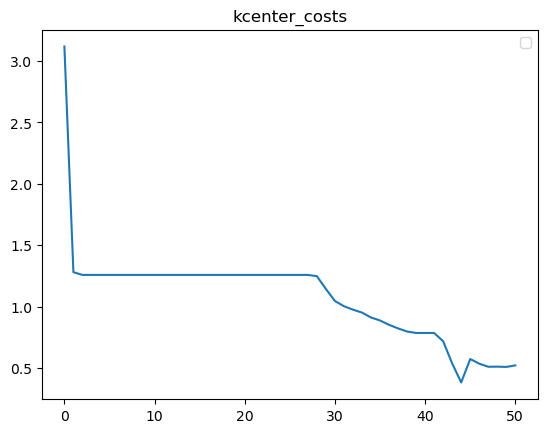

No handles with labels found to put in legend.


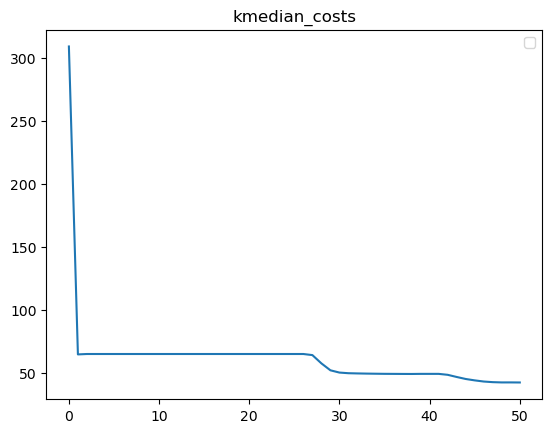

In [7]:

kmean_costs, kmedian_costs, kcenter_costs = [info['kmean_cost'] for info in infos], [info['kmedian_cost'] for info in infos], [info['kcenter_cost'] for info in infos]
costs = {
    'kcenter_costs': kcenter_costs,
    'kmedian_costs': kmedian_costs,
    'kcenter_costs': kcenter_costs,
}
for costname, cost in costs.items():
    if 'cost' not in costname:
        continue
    plt.plot(cost)
    plt.title(costname)
    plt.legend()
    plt.show()

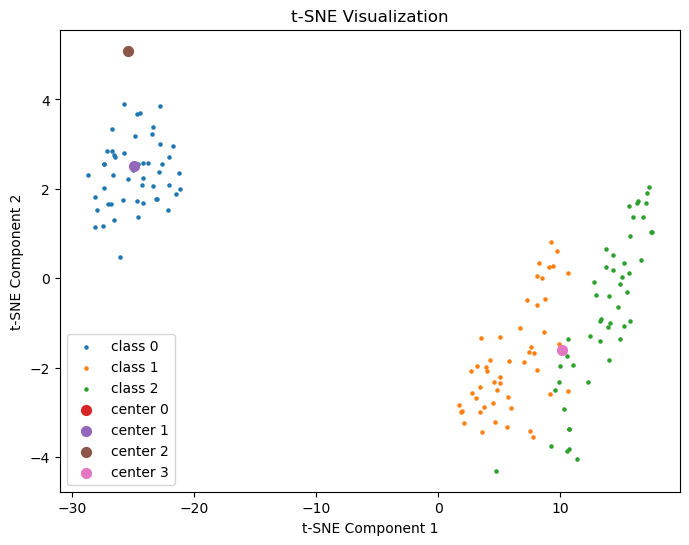

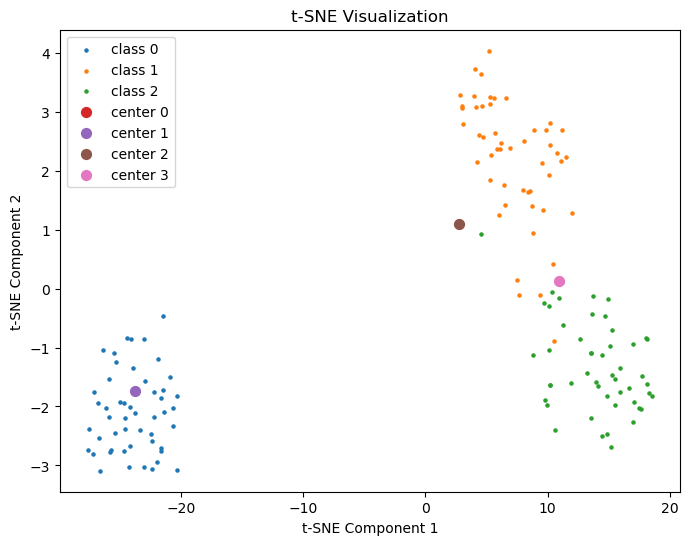

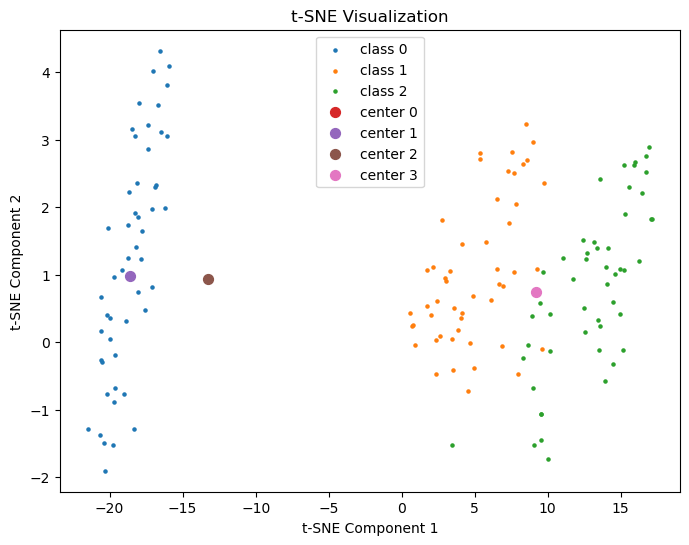

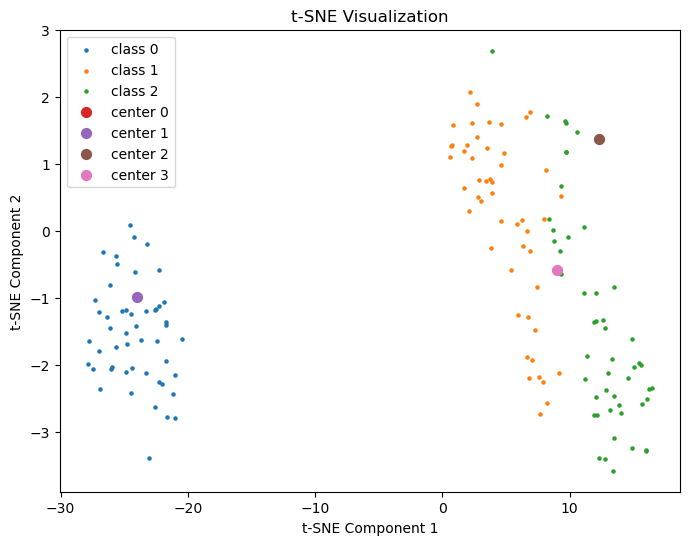

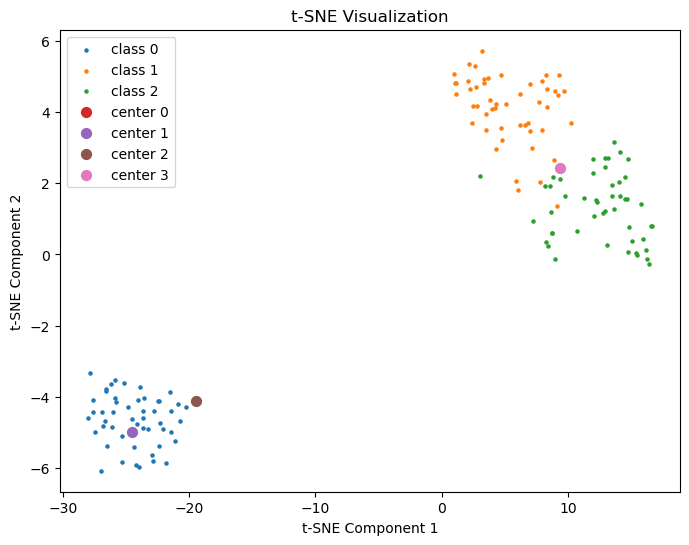

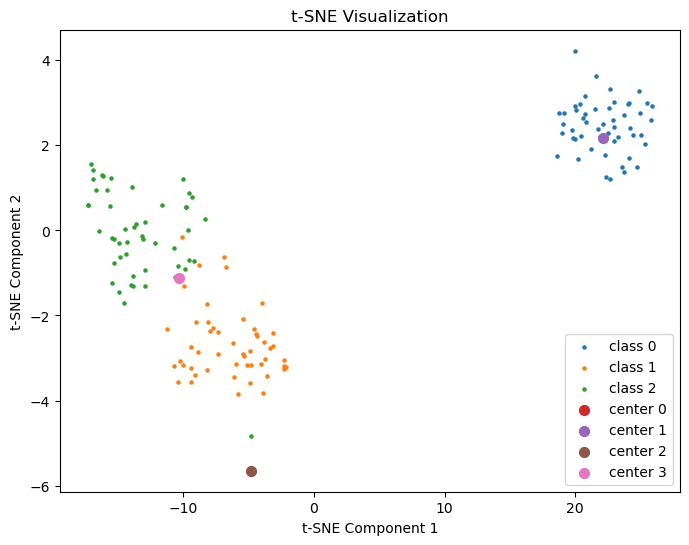

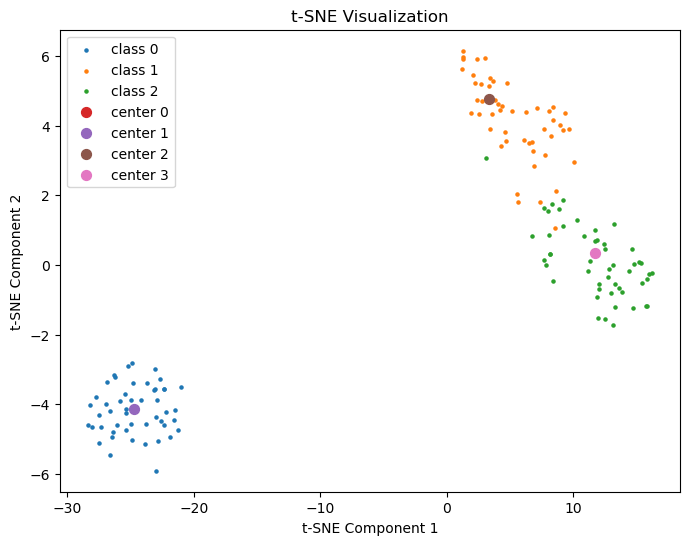

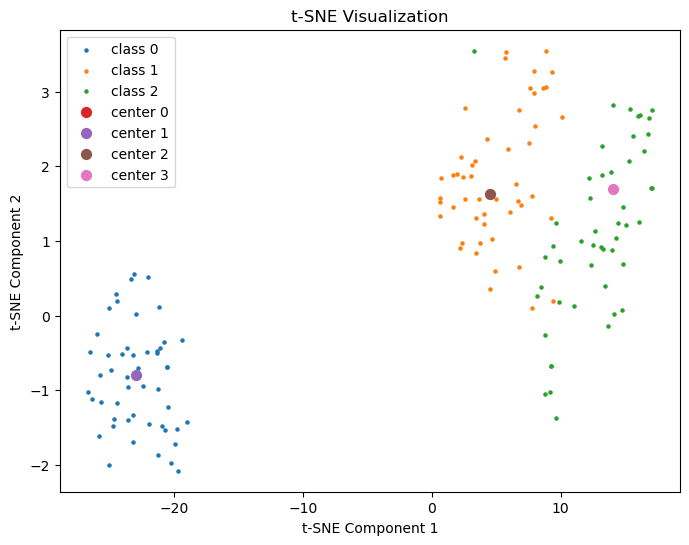

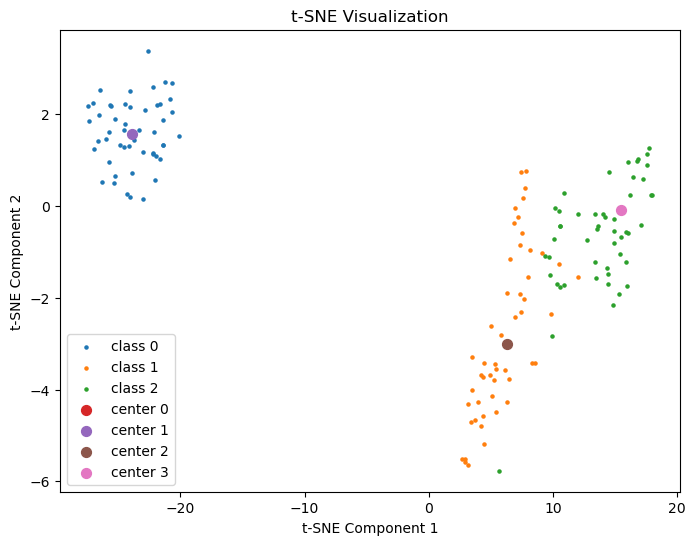

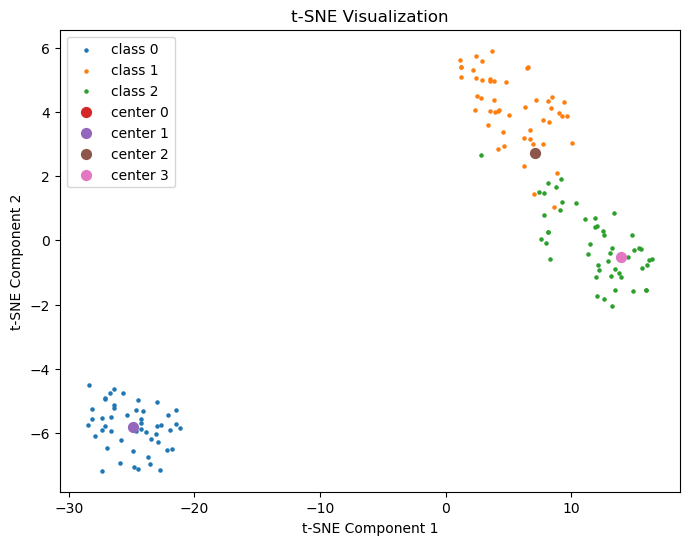

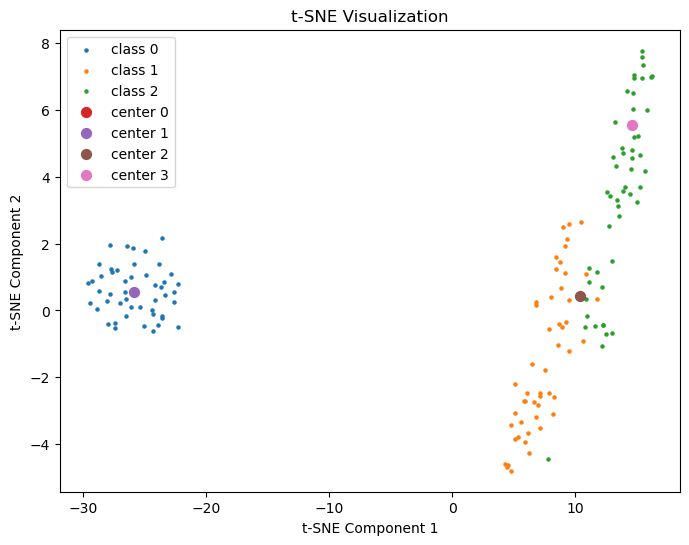

In [8]:
for info in infos[::5]:
    centers = info['centers']
    visualize(features, classes, centers)
